In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import ParameterGrid

In [ ]:
%%capture
!pip install shap
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
df_track_all = pd.read_csv('/content/drive/My Drive/OJT-BlueBird/Dataset/Data for Modeling/clean_df_track.csv', parse_dates=['time', 'time0'])
df_track_all.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_track_all.head()

,order_id,time,car_lat,car_lon,direction,speed,city,car_lat0,car_lon0,distance_geopy,distance_vincenty,distance_haversine,distance_osrm,time0,time_diff_min,is_holiday
0,1078,2020-07-05 13:15:52+07:00,-6.254242,106.804037,21,0.0,JKT,-6.254242,106.804037,0.000000,0.000000,0.000000,0.0,2020-07-05 13:15:52+07:00,0.000000,0
1,1078,2020-07-05 13:17:12+07:00,-6.254242,106.804037,21,0.0,JKT,-6.254242,106.804037,0.000000,0.000000,0.000000,0.0,2020-07-05 13:15:52+07:00,1.333333,0
2,1078,2020-07-05 13:17:52+07:00,-6.254242,106.804037,21,0.0,JKT,-6.254242,106.804037,0.000000,0.000000,0.000000,0.0,2020-07-05 13:17:12+07:00,0.666667,0
3,1078,2020-07-05 13:18:52+07:00,-6.253781,106.803533,291,15.0,JKT,-6.254242,106.804037,75.561121,75.561120,75.702304,101.0,2020-07-05 13:17:52+07:00,1.000000,0
4,1078,2020-07-05 13:20:12+07:00,-6.254601,106.802262,83,5.0,JKT,-6.253781,106.803533,167.300820,167.300816,167.434229,321.4,2020-07-05 13:18:52+07:00,1.333333,0


In [ ]:
df_order = pd.read_csv('/content/drive/My Drive/OJT-BlueBird/Dataset/Data for Modeling/df_order_clean.csv', parse_dates=['dispatched_at', 'pickup_time'])
df_order = df_order.drop('Unnamed: 0', axis=1)
df_order.head()

,order_id,dispatched_at,pickup_time,pickup_lat,pickup_lon,duration,avg_speed,distance_geopy,distance_osrm,sub_district,province,dispatch_lat,dispatch_lon
0,1078,2020-07-05 13:15:33+07:00,2020-07-05 13:22:20+07:00,-6.2546,106.802498,3.366667,10.000000,260.413119,439.8,Kebayoran Baru,Jakarta,-6.254242,106.804037
1,1081,2020-07-05 10:56:18+07:00,2020-07-05 11:15:18+07:00,-6.1600,106.794800,16.666667,10.142857,1791.284617,2484.9,Grogol Petamburan,Jakarta,-6.163238,106.790207
2,1082,2020-07-05 07:29:46+07:00,2020-07-05 07:44:40+07:00,-6.5345,106.798698,11.766667,23.533333,3016.081773,3400.5,Tanah Sereal,Jawa Barat,-6.537536,106.782627
3,1083,2020-07-05 10:53:19+07:00,2020-07-05 11:09:14+07:00,-6.1794,106.883301,6.616667,12.125000,753.654807,957.6,Pulo Gadung,Jakarta,-6.181155,106.884764
4,1087,2020-07-05 12:38:29+07:00,2020-07-05 12:46:01+07:00,-6.1884,106.872803,7.216667,18.625000,1100.406517,1693.6,Cempaka Putih,Jakarta,-6.188753,106.875225


# Data Cleansing

In [ ]:
df_track = df_track_all[(df_track_all['distance_osrm']>0) & (df_track_all['distance_geopy']>0) 
& (df_track_all['distance_haversine']>0) & (df_track_all['distance_vincenty']>0) & (df_track_all['speed']>0) & (df_track_all['time_diff_min']>0)]

In [ ]:
def outlier_handler(data, column, mode):
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  number_of_outliers = ((data[column]<lower_bound)|(data[column]>upper_bound)).sum()
  print('The number of outliers in column {} is {}'.format(column, number_of_outliers))

  if mode == 'upper':
    data[column].loc[data[column] > upper_bound]  = upper_bound

  elif mode == 'remove':
    data.drop(data[data[column] > upper_bound].index, inplace=True)

In [ ]:
def distribution(column, data):
    skewness = data[column].skew()
    print('Skewness of column {} is {}'.format(column,skewness))
    sns.set(style='ticks')
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={'height_ratios': (.15, .85)})

    sns.boxplot(data[column], ax=ax_box, color = 'skyblue')
    sns.distplot(data[column], ax=ax_hist, color = 'g')

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()

### Distance OSRM

Skewness of column distance_osrm is 15.710742467173175


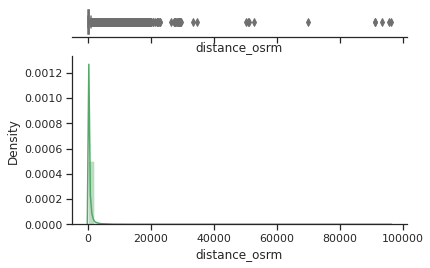

In [ ]:
distribution('distance_osrm', df_track)

In [ ]:
outlier_handler(df_track, 'distance_osrm', 'upper')

The number of outliers in column distance_osrm is 49871


Skewness of column distance_osrm is 1.1512033878896122


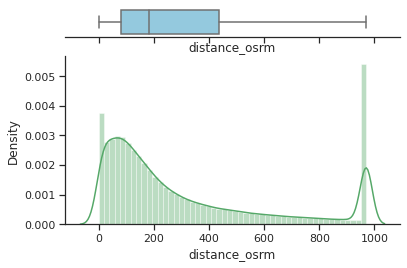

In [ ]:
distribution('distance_osrm', df_track)

## Distance Geopy

Skewness of column distance_geopy is 12.30187122948565


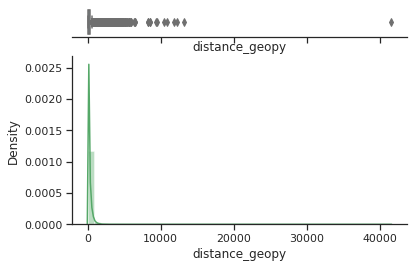

In [ ]:
distribution('distance_geopy', df_track)

In [ ]:
outlier_handler(df_track, 'distance_geopy', 'upper')

The number of outliers in column distance_geopy is 36825


Skewness of column distance_geopy is 1.0804327820212252


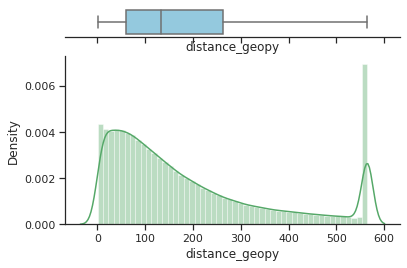

In [ ]:
distribution('distance_geopy', df_track)

## Duration

Skewness of column time_diff_min is 3.3466078670399644


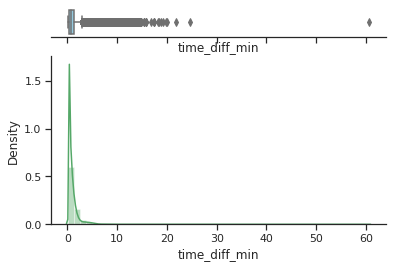

In [ ]:
distribution('time_diff_min', df_track)

In [ ]:
outlier_handler(df_track, 'time_diff_min', 'upper')

The number of outliers in column time_diff_min is 33726


Skewness of column time_diff_min is 1.240817101916929


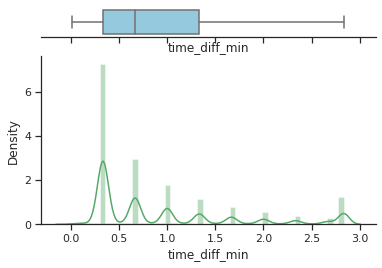

In [ ]:
distribution('time_diff_min', df_track)

# Feature Engineering

## Time

In [ ]:
df_track['month'] = df_track['time'].dt.month
df_track['day_of_week'] = df_track['time'].dt.dayofweek
df_track['day_of_month'] = df_track['time'].dt.day
df_track['hour'] = df_track['time'].dt.hour
df_track['minute'] = df_track['time'].dt.minute
df_track['second'] = df_track['time'].dt.second
df_track['minute_of_day'] = df_track['hour'] * 60 + df_track['minute']
df_track['second_from_midnight'] = (df_track['hour'] * 3600) + (df_track['minute'] * 60) + (df_track['second'])
df_track['second_from_firstday'] = (df_track['day_of_month'] * 24 * 3600) + (df_track['hour'] * 3600) + (df_track['minute'] * 60) + (df_track['second'])
df_track['week_hour'] = df_track['day_of_week'] * 24 + df_track['hour']

##Rush hour

In [ ]:
rush_hour = df_track.groupby(['day_of_week', 'hour'], as_index = False).agg(order_count = ('order_id', 'nunique'))
rush_hour.head()

,day_of_week,hour,order_count
0,0,0,119
1,0,1,136
2,0,2,219
3,0,3,314
4,0,4,469


In [ ]:
#1 is the best and 3 is the worst
rh_labels = range(4,0,-1) #The mode order (1), the better

rh_quartiles = pd.qcut(rush_hour['order_count'], q=4, labels=rh_labels)

rush_hour = rush_hour.assign(rush_hour = rh_quartiles.values)

rush_hour.head()

,day_of_week,hour,order_count,rush_hour
0,0,0,119,4
1,0,1,136,4
2,0,2,219,4
3,0,3,314,3
4,0,4,469,3


In [ ]:
#Merge rush_hour and df_track
rh_join = pd.merge(df_track, rush_hour, on=['day_of_week','hour'])
rh_join.drop('order_count', axis=1, inplace=True)
df_track = rh_join
df_track.head()

,order_id,time,car_lat,car_lon,direction,speed,city,car_lat0,car_lon0,distance_geopy,distance_vincenty,distance_haversine,distance_osrm,time0,time_diff_min,is_holiday,month,day_of_week,day_of_month,hour,minute,second,minute_of_day,second_from_midnight,second_from_firstday,week_hour,rush_hour
0,1078,2020-07-05 13:18:52+07:00,-6.253781,106.803533,291,15.0,JKT,-6.254242,106.804037,75.561121,75.561120,75.702304,101.0,2020-07-05 13:17:52+07:00,1.000000,0,7,6,5,13,18,52,798,47932,479932,157,1
1,1078,2020-07-05 13:20:12+07:00,-6.254601,106.802262,83,5.0,JKT,-6.253781,106.803533,167.300820,167.300816,167.434229,321.4,2020-07-05 13:18:52+07:00,1.333333,0,7,6,5,13,20,12,800,48012,480012,157,1
2,1092,2020-07-05 13:00:39+07:00,-6.112207,106.743083,121,23.0,JKT,-6.111053,106.742371,150.033919,150.033918,150.584161,200.3,2020-07-05 12:58:59+07:00,1.666667,0,7,6,5,13,0,39,780,46839,478839,157,1
3,1092,2020-07-05 13:01:59+07:00,-6.111512,106.744656,266,19.0,JKT,-6.112207,106.743083,190.298239,190.298233,190.285262,489.5,2020-07-05 13:00:39+07:00,1.333333,0,7,6,5,13,1,59,781,46919,478919,157,1
4,1104,2020-07-05 13:00:55+07:00,-6.203073,106.807606,313,39.0,JKT,-6.206592,106.808645,405.776306,405.776304,407.790561,564.7,2020-07-05 12:59:55+07:00,1.000000,0,7,6,5,13,0,55,780,46855,478855,157,1


## Weather

In [ ]:
weather = pd.read_csv('/content/drive/My Drive/OJT-BlueBird/Dataset/Weather/Jakarta_HourlyWeather.csv', parse_dates=['date_time'])
weather.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2020-06-01 00:00:00,35,29,0.0,11.6,7,71,01:57 PM,01:29 AM,05:57 AM,05:44 PM,23,35,35,31,5,41,62,0.1,1012,31,10,132,5,Jakarta
1,2020-06-01 01:00:00,35,29,0.0,11.6,7,71,01:57 PM,01:29 AM,05:57 AM,05:44 PM,23,35,35,31,5,33,63,0.1,1012,31,10,133,5,Jakarta
2,2020-06-01 02:00:00,35,29,0.0,11.6,7,71,01:57 PM,01:29 AM,05:57 AM,05:44 PM,23,35,35,30,5,26,64,0.0,1011,30,10,134,4,Jakarta
3,2020-06-01 03:00:00,35,29,0.0,11.6,7,71,01:57 PM,01:29 AM,05:57 AM,05:44 PM,23,34,34,30,5,18,65,0.0,1011,30,10,135,4,Jakarta
4,2020-06-01 04:00:00,35,29,0.0,11.6,7,71,01:57 PM,01:29 AM,05:57 AM,05:44 PM,23,34,34,30,5,19,65,0.0,1011,30,10,134,4,Jakarta


In [ ]:
weather['month'] = weather['date_time'].dt.month
weather['day_of_month'] = weather['date_time'].dt.day
weather['hour'] = weather['date_time'].dt.hour

In [ ]:
weather = weather[['month','day_of_month','hour','tempC','precipMM','sunHour']]
weather_join = pd.merge(df_track, weather, on=['month','day_of_month','hour'])
df_track = weather_join
df_track.head()

,order_id,time,car_lat,car_lon,direction,speed,city,car_lat0,car_lon0,distance_geopy,distance_vincenty,distance_haversine,distance_osrm,time0,time_diff_min,is_holiday,month,day_of_week,day_of_month,hour,minute,second,minute_of_day,second_from_midnight,second_from_firstday,week_hour,rush_hour,tempC,precipMM,sunHour
0,1078,2020-07-05 13:18:52+07:00,-6.253781,106.803533,291,15.0,JKT,-6.254242,106.804037,75.561121,75.561120,75.702304,101.0,2020-07-05 13:17:52+07:00,1.000000,0,7,6,5,13,18,52,798,47932,479932,157,1,33,0.0,8.7
1,1078,2020-07-05 13:20:12+07:00,-6.254601,106.802262,83,5.0,JKT,-6.253781,106.803533,167.300820,167.300816,167.434229,321.4,2020-07-05 13:18:52+07:00,1.333333,0,7,6,5,13,20,12,800,48012,480012,157,1,33,0.0,8.7
2,1092,2020-07-05 13:00:39+07:00,-6.112207,106.743083,121,23.0,JKT,-6.111053,106.742371,150.033919,150.033918,150.584161,200.3,2020-07-05 12:58:59+07:00,1.666667,0,7,6,5,13,0,39,780,46839,478839,157,1,33,0.0,8.7
3,1092,2020-07-05 13:01:59+07:00,-6.111512,106.744656,266,19.0,JKT,-6.112207,106.743083,190.298239,190.298233,190.285262,489.5,2020-07-05 13:00:39+07:00,1.333333,0,7,6,5,13,1,59,781,46919,478919,157,1,33,0.0,8.7
4,1104,2020-07-05 13:00:55+07:00,-6.203073,106.807606,313,39.0,JKT,-6.206592,106.808645,405.776306,405.776304,407.790561,564.7,2020-07-05 12:59:55+07:00,1.000000,0,7,6,5,13,0,55,780,46855,478855,157,1,33,0.0,8.7


## Cluster Location

In [ ]:
address = df_order[['order_id', 'sub_district', 'province']]

In [ ]:
df_track = pd.merge(df_track,address, on='order_id')
df_track.head()

,order_id,time,car_lat,car_lon,direction,speed,city,car_lat0,car_lon0,distance_geopy,distance_vincenty,distance_haversine,distance_osrm,time0,time_diff_min,is_holiday,month,day_of_week,day_of_month,hour,minute,second,minute_of_day,second_from_midnight,second_from_firstday,week_hour,rush_hour,tempC,precipMM,sunHour,sub_district,province
0,1078,2020-07-05 13:18:52+07:00,-6.253781,106.803533,291,15.0,JKT,-6.254242,106.804037,75.561121,75.561120,75.702304,101.0,2020-07-05 13:17:52+07:00,1.000000,0,7,6,5,13,18,52,798,47932,479932,157,1,33,0.0,8.7,Kebayoran Baru,Jakarta
1,1078,2020-07-05 13:20:12+07:00,-6.254601,106.802262,83,5.0,JKT,-6.253781,106.803533,167.300820,167.300816,167.434229,321.4,2020-07-05 13:18:52+07:00,1.333333,0,7,6,5,13,20,12,800,48012,480012,157,1,33,0.0,8.7,Kebayoran Baru,Jakarta
2,1092,2020-07-05 13:00:39+07:00,-6.112207,106.743083,121,23.0,JKT,-6.111053,106.742371,150.033919,150.033918,150.584161,200.3,2020-07-05 12:58:59+07:00,1.666667,0,7,6,5,13,0,39,780,46839,478839,157,1,33,0.0,8.7,Penjaringan,Jakarta
3,1092,2020-07-05 13:01:59+07:00,-6.111512,106.744656,266,19.0,JKT,-6.112207,106.743083,190.298239,190.298233,190.285262,489.5,2020-07-05 13:00:39+07:00,1.333333,0,7,6,5,13,1,59,781,46919,478919,157,1,33,0.0,8.7,Penjaringan,Jakarta
4,1092,2020-07-05 12:22:34+07:00,-6.111349,106.745713,109,20.0,JKT,-6.113033,106.749253,433.865527,433.865514,433.897483,695.9,2020-07-05 12:19:54+07:00,2.666667,0,7,6,5,12,22,34,742,44554,476554,156,1,33,0.0,8.7,Penjaringan,Jakarta


# Data Prep

## Aggregation

In [ ]:
summ_track = df_track.groupby('order_id', as_index=False).agg(
                                                              pickup_lat = ('car_lat', 'last'),
                                                              pickup_lon = ('car_lon', 'last'),
                                                              distance_geopy = ('distance_geopy', 'sum'),
                                                              distance_osrm = ('distance_osrm', 'sum'),
                                                              second_from_midnight = ('second_from_midnight', 'first'),
                                                              second_from_firstday = ('second_from_firstday', 'first'),
                                                              sunHour = ('sunHour', lambda x:x.value_counts().index[0]),
                                                              day_of_week = ('day_of_week', lambda x:x.value_counts().index[0]),
                                                              sub_district = ('sub_district', lambda x:x.value_counts().index[0]),
                                                              week_hour = ('week_hour', lambda x:x.value_counts().index[0]),
                                                              hour = ('hour', lambda x:x.value_counts().index[0]),
                                                              eta = ('time_diff_min', 'sum')
                                                              )

In [ ]:
summ_track = summ_track.merge(df_order[['order_id', 'dispatch_lat', 'dispatch_lon']], on = 'order_id')

In [ ]:
summ_track['eta_sec'] = summ_track['eta'] * 60

In [ ]:
summ_track.head()

,order_id,pickup_lat,pickup_lon,distance_geopy,distance_osrm,second_from_midnight,second_from_firstday,sunHour,day_of_week,sub_district,week_hour,hour,eta,dispatch_lat,dispatch_lon,eta_sec
0,1078,-6.254601,106.802262,242.861941,422.4,47932,479932,8.7,6,Kebayoran Baru,157,13,2.333333,-6.254242,106.804037,140.0
1,1081,-6.159643,106.795354,1791.284617,2484.9,39497,471497,8.7,6,Grogol Petamburan,155,11,16.500000,-6.163238,106.790207,990.0
2,1082,-6.534558,106.797237,3016.081773,3400.5,27134,459134,8.7,6,Tanah Sereal,151,7,11.766667,-6.537536,106.782627,706.0
3,1083,-6.179375,106.883498,673.030354,877.9,39297,471297,8.7,6,Pulo Gadung,155,11,4.000000,-6.181155,106.884764,240.0
4,1087,-6.188295,106.873416,1083.364644,1512.3,45547,477547,8.7,6,Cempaka Putih,156,12,6.650000,-6.188753,106.875225,399.0


### Traffic

In [ ]:
traffic = pd.read_csv('/content/drive/My Drive/OJT-BlueBird/Dataset/Data for Modeling/traffic_by_hour.csv')
traffic.drop('Unnamed: 0', axis = 1, inplace = True)
traffic.head()

,sub_district,hour,avg_speed,traffic
0,Babakan Madang,1,35.400000,1
1,Babakan Madang,2,11.687500,3
2,Babakan Madang,7,28.000000,1
3,Babakan Madang,8,14.307692,2
4,Babakan Madang,9,1.000000,4


In [ ]:
summ_track = summ_track.merge(traffic[['sub_district', 'hour', 'traffic']], on = ['sub_district', 'hour'])

In [ ]:
summ_track.head()

,order_id,pickup_lat,pickup_lon,distance_geopy,distance_osrm,second_from_midnight,second_from_firstday,sunHour,day_of_week,sub_district,week_hour,hour,eta,dispatch_lat,dispatch_lon,eta_sec,traffic
0,1078,-6.254601,106.802262,242.861941,422.40,47932,479932,8.7,6,Kebayoran Baru,157,13,2.333333,-6.254242,106.804037,140.0,3
1,7339,-6.229493,106.813414,431.991263,1682.20,47869,479869,8.7,6,Kebayoran Baru,157,13,3.450000,-6.232894,106.815582,207.0,3
2,27080,-6.227284,106.808731,690.761855,1639.85,49307,481307,8.7,6,Kebayoran Baru,157,13,2.000000,-6.226572,106.811628,120.0,3
3,85331,-6.266015,106.808937,711.787704,882.20,47645,2466845,11.6,4,Kebayoran Baru,109,13,4.833333,-6.257221,106.808023,290.0,3
4,100631,-6.240156,106.814575,83.515109,254.40,46918,2466118,11.6,4,Kebayoran Baru,109,13,2.833333,-6.239013,106.811033,170.0,3


### Manhattan

In [ ]:
from geopy.distance import geodesic,distance
def distancer_manhattan(row):
    coords_1 = (row['dispatch_lat'], row['dispatch_lon'])
    coords_2 = (row['pickup_lat'], row['pickup_lon'])

    coords_temp = (row['dispatch_lat'], row['pickup_lon'])

    D1 = geodesic(coords_1, coords_temp).meters
    D2 = geodesic(coords_temp, coords_2).meters

    straight = np.sqrt(D1*D1+D2*D2)

    return D1+D2

summ_track['distance_manhattan'] = summ_track.apply(distancer_manhattan, axis = 1)

### Coord Average

In [ ]:
summ_track['lat_avg'] = summ_track.apply(lambda x: (x['dispatch_lat']+x['pickup_lat'])/2, axis = 1)
summ_track['lon_avg'] = summ_track.apply(lambda x: (x['dispatch_lon']+x['pickup_lon'])/2, axis = 1)

## Modelling Data

In [ ]:
summ_track.head()

,order_id,pickup_lat,pickup_lon,distance_geopy,distance_osrm,second_from_midnight,second_from_firstday,sunHour,day_of_week,sub_district,week_hour,hour,eta,dispatch_lat,dispatch_lon,eta_sec,traffic,distance_manhattan,lat_avg,lon_avg
0,1078,-6.254601,106.802262,242.861941,422.40,47932,479932,8.7,6,Kebayoran Baru,157,13,2.333333,-6.254242,106.804037,140.0,3,236.155788,-6.254421,106.803149
1,7339,-6.229493,106.813414,431.991263,1682.20,47869,479869,8.7,6,Kebayoran Baru,157,13,3.450000,-6.232894,106.815582,207.0,3,616.060952,-6.231194,106.814498
2,27080,-6.227284,106.808731,690.761855,1639.85,49307,481307,8.7,6,Kebayoran Baru,157,13,2.000000,-6.226572,106.811628,120.0,3,399.356387,-6.226928,106.810180
3,85331,-6.266015,106.808937,711.787704,882.20,47645,2466845,11.6,4,Kebayoran Baru,109,13,4.833333,-6.257221,106.808023,290.0,3,1073.588274,-6.261618,106.808480
4,100631,-6.240156,106.814575,83.515109,254.40,46918,2466118,11.6,4,Kebayoran Baru,109,13,2.833333,-6.239013,106.811033,170.0,3,518.300014,-6.239585,106.812804


### Duration

Skewness of column eta_sec is 2.4527509837128436


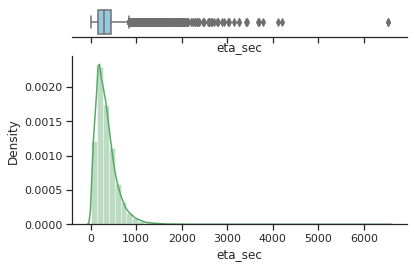

In [ ]:
distribution('eta_sec', summ_track)

In [ ]:
outlier_handler(summ_track, 'eta_sec', 'upper')

The number of outliers in column eta_sec is 3180


Skewness of column eta_sec is 0.8427034640514621


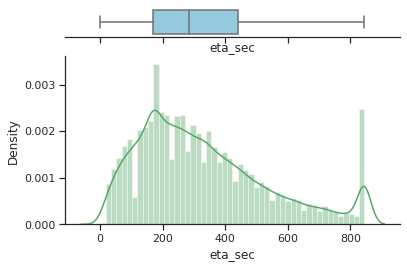

In [ ]:
distribution('eta_sec', summ_track)

In [ ]:
X = summ_track[['dispatch_lat', 'dispatch_lon', 'pickup_lat', 'pickup_lon','distance_geopy','distance_osrm','second_from_midnight',
                 'second_from_firstday','week_hour','traffic','sunHour','distance_manhattan','lat_avg','lon_avg']]
                                  
y = summ_track[['eta_sec']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.36, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52512, 14), (29539, 14), (52512, 1), (29539, 1))

In [ ]:
def model_score(model, xtrain, xtest, ytrain, ytest):
  print('Train score:', model.score(xtrain, ytrain), '\nTest score', model.score(xtest, ytest))

  # Make predictions for test data
  y_pred = model.predict(xtest)

  # Evaluate predictions
  mae = mean_absolute_error(ytest, y_pred)
  mse = mean_squared_error(ytest, y_pred)
  rmse = mean_squared_error(ytest, y_pred, squared = False)

  print('\nMAE:', mae, '\n'
        'MSE:', mse, '\n'
        'RMSE:', rmse, '\n')

# Baseline Modelling

## LightGBM

In [ ]:
%%time
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

CPU times: user 937 ms, sys: 9.99 ms, total: 947 ms
Wall time: 951 ms


In [ ]:
model_score(lgbm, X_train, X_test, y_train, y_test)

Train score: 0.7841084211011788 
Test score 0.7633835479220797

MAE: 75.41270010521244 
MSE: 10021.158490967515 
RMSE: 100.10573655374358 



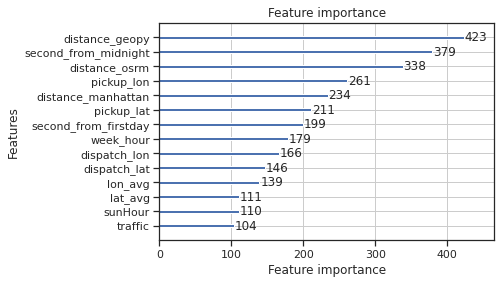

In [ ]:
import lightgbm as lgb

lgb.plot_importance(lgbm)
plt.show()

## XGBoost

In [ ]:
%%time

xgbmodel = XGBRegressor()
xgbmodel.fit(X_train, y_train)

[13:20:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5.11 s, sys: 6 ms, total: 5.12 s
Wall time: 5.12 s


In [ ]:
model_score(xgbmodel, X_train, X_test, y_train, y_test)

Train score: 0.7516486543704634 
Test score 0.7480612381544578

MAE: 78.23129785778826 
MSE: 10670.087562807685 
RMSE: 103.29611591346348 



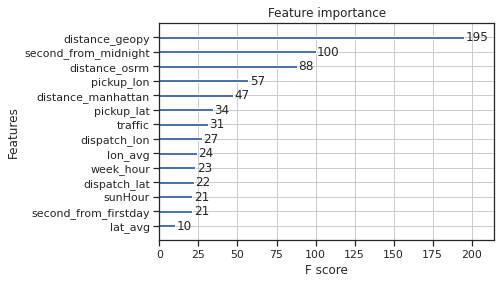

In [ ]:
# plot feature importance
xgb.plot_importance(xgbmodel)
plt.show()

## SVM

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR

In [ ]:
svm_model = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
svm_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvr',
                 LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
                           intercept_scaling=1.0, loss='epsilon_insensitive',
                           max_iter=1000, random_state=0, tol=1e-05,
                           verbose=0))],
         verbose=False)

In [ ]:
svm_model.get_params()

{'linearsvr': LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
           intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
           random_state=0, tol=1e-05, verbose=0),
 'linearsvr__C': 1.0,
 'linearsvr__dual': True,
 'linearsvr__epsilon': 0.0,
 'linearsvr__fit_intercept': True,
 'linearsvr__intercept_scaling': 1.0,
 'linearsvr__loss': 'epsilon_insensitive',
 'linearsvr__max_iter': 1000,
 'linearsvr__random_state': 0,
 'linearsvr__tol': 1e-05,
 'linearsvr__verbose': 0,
 'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('linearsvr', LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
             intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
             random_state=0, tol=1e-05, verbose=0

In [ ]:
svm_model.score(X_train,y_train)

0.5600180490597211

In [ ]:
svm_model.score(X_test,y_test)

0.5409871964359517

In [ ]:
# Make predictions for test data
y_pred = svm_model.predict(X_test)

# Evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)

print('MAE:', mae, '\n'
      'MSE:', mse, '\n'
      'RMSE:', rmse, '\n')

MAE: 91.00555490806111 
MSE: 19440.068573016604 
RMSE: 139.42764637264952 



# Hyperopt

## LightGBM

In [ ]:
%%time

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from numpy import sqrt

# Choose hyperparameter domain to search over
space = {
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
        'max_depth':        hp.choice('max_depth',        np.arange(1, 16, 1, dtype=int)),
        'min_child_weight': hp.choice('min_child_weight', np.arange(1, 16, 1, dtype=int)),
        'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
        'subsample':        hp.uniform('subsample', 0.8, 1),
        'n_estimators':     hp.choice('n_estimators',    np.arange(100, 800, 10)),
        }

def score(params):
    model = LGBMRegressor(**params, silent = True)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    y_pred = model.predict(X_test)
    score = sqrt(mean_squared_error(y_test, y_pred))
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=100)
    return best

trials = Trials()
best_params = optimize(trials, space)

100%|██████████| 100/100 [03:55<00:00,  2.35s/it, best loss: 98.60915961751637]
CPU times: user 3min 52s, sys: 1.86 s, total: 3min 54s
Wall time: 3min 55s


In [ ]:
# Return the best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.7000000000000002,
 'learning_rate': 0.1,
 'max_depth': 13,
 'min_child_weight': 15,
 'n_estimators': 600,
 'subsample': 0.9490105717917737}

In [ ]:
%%time
lgbm = LGBMRegressor(
                    colsample_bytree = 0.7000000000000002,
                    learning_rate = 0.1,
                    max_depth = 13,
                    min_child_weight = 15,
                    n_estimators = 600,
                    subsample = 0.9490105717917737
                     )
lgbm.fit(X_train, y_train)

CPU times: user 2.59 s, sys: 46.6 ms, total: 2.63 s
Wall time: 2.64 s


In [ ]:
model_score(lgbm, X_train, X_test, y_train, y_test)

Train score: 0.8457233153628804 
Test score 0.7708692568165574

MAE: 74.22542782698977 
MSE: 9704.124427655206 
RMSE: 98.50951440168207 



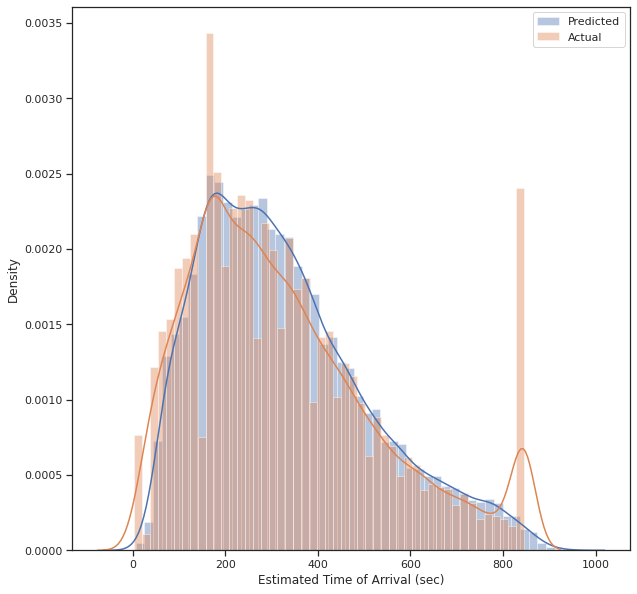

In [ ]:
x = lgbm.predict(X_test)
y = y_test.reset_index(drop = True)

fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(x, ax=ax, kde=True, label = ['Predicted'])
sns.distplot(y, ax=ax, kde=True, label = ['Actual'])

plt.xlabel('Estimated Time of Arrival (sec)')

plt.legend()
plt.show()

In [ ]:
error = pd.DataFrame()
error['predicted'] = pd.Series(x)

error['actual'] = y

In [ ]:
error['abs_error'] = abs(error['actual'] - error['predicted'])
error['squared_error'] = (error['predicted'] - error['actual'])**2

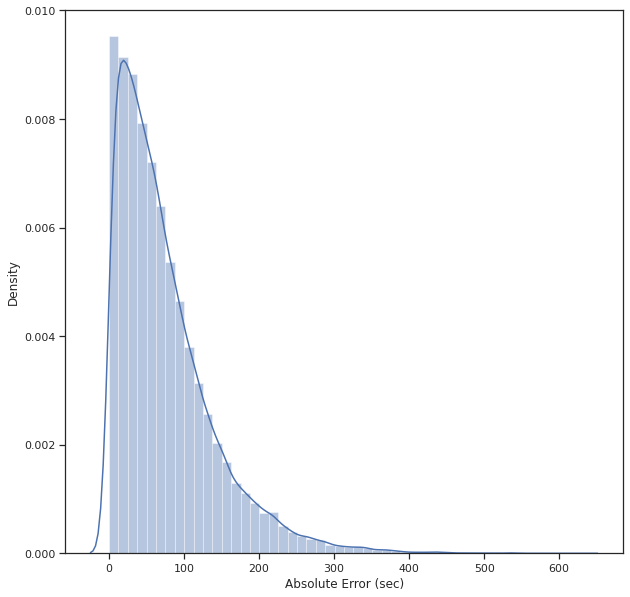

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot((error['abs_error']), kde = True)

plt.xlabel('Absolute Error (sec)')

plt.show()

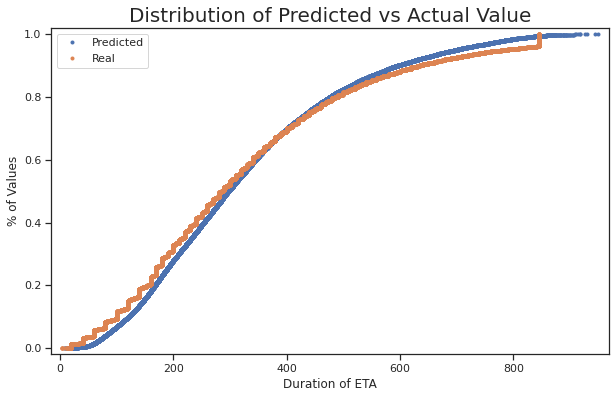

In [ ]:
#Empirical Cumulative Distribution Function
x1 = np.sort(error['predicted'])
x2 = np.sort(error['actual'])
y1 = np.arange(1,len(x1)+1)/len(x1)
plt.figure(figsize=(10,6))
plt.plot(x1,y1,marker='.',linestyle='none')
plt.plot(x2,y1,marker='.',linestyle='none')
plt.title('Distribution of Predicted vs Actual Value',fontsize=20)
plt.xlabel('Duration of ETA')
plt.ylabel('% of Values')
plt.legend(['Predicted','Real'])
plt.margins(0.02)

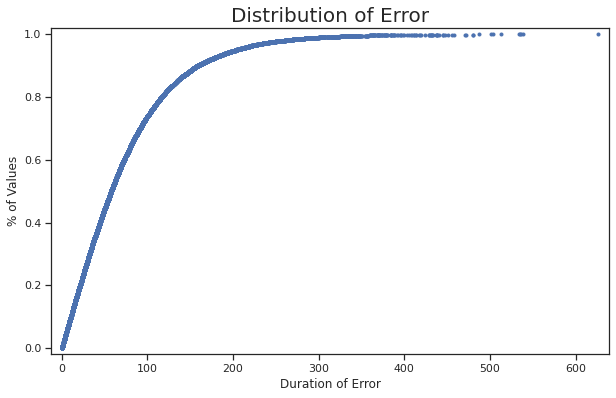

In [ ]:
x3 = np.sort(abs(error['predicted'] - error['actual']))
plt.figure(figsize=(10,6))
plt.plot(x3,y1,marker='.',linestyle='none')
plt.title('Distribution of Error',fontsize=20)
plt.xlabel('Duration of Error')
plt.ylabel('% of Values')
plt.margins(0.02)

## XGBoost

In [ ]:
%%time

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from numpy import sqrt

# Choose hyperparameter domain to search over
space = {
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
        'max_depth':        hp.choice('max_depth',        np.arange(1, 16, 1, dtype=int)),
        'min_child_weight': hp.choice('min_child_weight', np.arange(1, 16, 1, dtype=int)),
        'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
        'subsample':        hp.uniform('subsample', 0.8, 1),
        'n_estimators':     hp.choice('n_estimators',    np.arange(100, 800, 10)),
        }

def score(params):
    model = XGBRegressor(**params, silent = True)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    y_pred = model.predict(X_test)
    score = sqrt(mean_squared_error(y_test, y_pred))
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=100)
    return best

trials = Trials()
best_params = optimize(trials, space)

In [ ]:
# Return the best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.7000000000000002,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_child_weight': 4,
 'n_estimators': 500,
 'subsample': 0.8389808310384133}

In [ ]:
%%time

xgbmodel = XGBRegressor(
                        colsample_bytree = 0.7000000000000002,
                        learning_rate = 0.05,
                        max_depth = 8,
                        min_child_weight = 4,
                        n_estimators = 500,
                        subsample = 0.8389808310384133
                      )
xgbmodel.fit(X_train, y_train)

[12:20:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 51.6 s, sys: 44.7 ms, total: 51.7 s
Wall time: 51.7 s


In [ ]:
model_score(xgbmodel, X_train, X_test, y_train, y_test)

Train score: 0.8763815047230178 
Test score 0.7680777460084274

MAE: 74.63573835569154 
MSE: 9822.35023990053 
RMSE: 99.10777083508906 



# GMaps Test

In [ ]:
real_df = pd.read_csv('/content/drive/My Drive/OJT-BlueBird/Dataset/Data for Modeling/real_df.csv')
real_df = real_df.dropna()
real_df['traffic'] = real_df['traffic'].astype('int')
real_df.drop(['Unnamed: 0',	'Unnamed: 0.1'], axis = 1, inplace = True)
real_df.head()

,order_id,dispatched_at,pickup_time,pickup_lat,pickup_lon,time,dispatch_lat,dispatch_lon,direction,speed,city,g_origin,g_destination,g_distance,g_ETA_text,g_ETA_seconds,distance_manhattan,distance_geopy,distance_osrm,day_of_week,sunHour,second_from_midnight,second_from_firstday,week_hour,traffic,lat_avg,lon_avg,result_xgb
0,3602212,2020-06-16 10:30:56 UTC,2020-06-16 10:44:27 UTC,-6.292563,106.783668,2020-06-16 10:40:14 UTC,-6.292451,106.783850,148,0,JKT,"Menara FIF, Jl. Tol Tahi Bonar Simatupang No.K...","Jalan TB Simatupang Kav. 15 4 1, RT.4/RW.1, Lb...",14 m,1 min,5,32.405239,23.562117,8.1,4,11.6,72378,2491578,116,3,-6.292507,106.783759,77.10055
1,3602372,2020-06-16 01:14:23 UTC,2020-06-16 01:20:36 UTC,-6.284620,106.844130,2020-06-16 01:20:20 UTC,-6.284654,106.844186,19,0,JKT,"Jl. Raya Pasar Minggu No.40b, RT.2/RW.1, Ps. M...","Jl. Raya Pasar Minggu No.40b, RT.2/RW.1, Ps. M...",3 m,1 min,0,9.973277,7.276059,2.6,4,11.6,72378,2491578,116,2,-6.284637,106.844158,75.43719
2,3602366,2020-06-16 09:08:12 UTC,2020-06-16 09:18:09 UTC,-6.228080,106.807410,2020-06-16 09:12:23 UTC,-6.229363,106.806424,112,0,JKT,"2, Jl. Senopati No.Kelurahan, RT.3/RW.5, Senay...",Prosperity Tower Lt. 20 District 8 SCBD Lot 28...,0.5 km,3 mins,164,250.936892,178.947790,125.7,4,11.6,72378,2491578,116,3,-6.228721,106.806917,114.11280
3,3602077,2020-06-16 07:01:09 UTC,2020-06-16 07:08:32 UTC,-6.215960,106.764980,2020-06-16 07:04:46 UTC,-6.216670,106.769068,265,48,JKT,"Jl. Raya Pos Pengumben No.41, RT.7/RW.5, Klp. ...","Jl. Wicaksana Blok I No.5, RT.6/RW.7, Klp. Dua...",0.8 km,4 mins,255,530.968775,459.214651,508.5,4,11.6,72378,2491578,116,2,-6.216315,106.767024,192.95557
4,4218340,2020-08-09 21:00:21 UTC,2020-08-09 21:52:41 UTC,-6.203800,107.012703,2020-08-09 21:28:06 UTC,-6.204407,107.005516,119,47,JKT,"Jl. Permata Hijau Permai No.1, RT.006/RW.024, ...","Gg. Kopi No.69, RT.008/RW.024, Kaliabang Tenga...",1.4 km,5 mins,310,862.494459,798.183041,1042.4,4,11.6,72378,2491578,116,3,-6.204104,107.009110,292.07614


In [ ]:
from geopy.distance import geodesic,distance
import geopy
from geopy.distance import distance
import numpy as np

def distancer_manhattan1(row):
    coords_1 = (row['pickup_lat'], row['pickup_lon'])
    coords_2 = (row['dispatch_lat'], row['dispatch_lon'])

    coords_temp = (row['pickup_lat'], row['dispatch_lon'])

    D1 = geodesic(coords_1, coords_temp).meters
    D2 = geodesic(coords_temp, coords_2).meters

    straight = np.sqrt(D1*D1+D2*D2)

    return D1+D2

def distancer_geopy(row):
    coords_1 = (row['dispatch_lat'], row['dispatch_lon'])
    coords_2 = (row['pickup_lat'], row['pickup_lon'])
    return geopy.distance.geodesic(coords_1, coords_2).m

import requests
def osrm(row):
    loc = '{},{};{},{}'.format(row['dispatch_lon'],row['dispatch_lat'],row['pickup_lon'],row['pickup_lat'])
    url = 'http://router.project-osrm.org/route/v1/driving/'
    res = requests.get(url+loc)
    path = res.json()
    return path['routes'][0]['distance']

In [ ]:
real_df['distance_manhattan'] = real_df.apply(distancer_manhattan1, axis=1)

In [ ]:
real_df['distance_geopy'] = real_df.apply(distancer_geopy, axis=1)

In [ ]:
real_df['distance_osrm'] = real_df.apply(osrm, axis=1)

In [ ]:
real_df['day_of_week'] = 4
real_df['sunHour'] = 11.6
real_df['second_from_midnight'] = 72378	
real_df['second_from_firstday'] = 2491578		
real_df['week_hour'] = 116
real_df['lat_avg'] = (real_df['dispatch_lat'].values + real_df['pickup_lat'].values)/2
real_df['lon_avg'] = (real_df['dispatch_lon'].values + real_df['pickup_lon'].values)/2
real_df.head()

,order_id,dispatched_at,pickup_time,pickup_lat,pickup_lon,time,dispatch_lat,dispatch_lon,direction,speed,city,g_origin,g_destination,g_distance,g_ETA_text,g_ETA_seconds,distance_manhattan,distance_geopy,distance_osrm,day_of_week,sunHour,second_from_midnight,second_from_firstday,week_hour,traffic,lat_avg,lon_avg,result_xgb
0,3602212,2020-06-16 10:30:56 UTC,2020-06-16 10:44:27 UTC,-6.292563,106.783668,2020-06-16 10:40:14 UTC,-6.292451,106.783850,148,0,JKT,"Menara FIF, Jl. Tol Tahi Bonar Simatupang No.K...","Jalan TB Simatupang Kav. 15 4 1, RT.4/RW.1, Lb...",14 m,1 min,5,32.405239,23.562117,8.1,4,11.6,72378,2491578,116,3,-6.292507,106.783759,77.10055
1,3602372,2020-06-16 01:14:23 UTC,2020-06-16 01:20:36 UTC,-6.284620,106.844130,2020-06-16 01:20:20 UTC,-6.284654,106.844186,19,0,JKT,"Jl. Raya Pasar Minggu No.40b, RT.2/RW.1, Ps. M...","Jl. Raya Pasar Minggu No.40b, RT.2/RW.1, Ps. M...",3 m,1 min,0,9.972170,7.275108,2.6,4,11.6,72378,2491578,116,2,-6.284637,106.844158,75.43719
2,3602366,2020-06-16 09:08:12 UTC,2020-06-16 09:18:09 UTC,-6.228080,106.807410,2020-06-16 09:12:23 UTC,-6.229363,106.806424,112,0,JKT,"2, Jl. Senopati No.Kelurahan, RT.3/RW.5, Senay...",Prosperity Tower Lt. 20 District 8 SCBD Lot 28...,0.5 km,3 mins,164,250.937998,178.948465,125.7,4,11.6,72378,2491578,116,3,-6.228721,106.806917,114.11280
3,3602077,2020-06-16 07:01:09 UTC,2020-06-16 07:08:32 UTC,-6.215960,106.764980,2020-06-16 07:04:46 UTC,-6.216670,106.769068,265,48,JKT,"Jl. Raya Pos Pengumben No.41, RT.7/RW.5, Klp. ...","Jl. Wicaksana Blok I No.5, RT.6/RW.7, Klp. Dua...",0.8 km,4 mins,255,530.965455,459.211379,508.5,4,11.6,72378,2491578,116,2,-6.216315,106.767024,192.95557
4,4218340,2020-08-09 21:00:21 UTC,2020-08-09 21:52:41 UTC,-6.203800,107.012703,2020-08-09 21:28:06 UTC,-6.204407,107.005516,119,47,JKT,"Jl. Permata Hijau Permai No.1, RT.006/RW.024, ...","Gg. Kopi No.69, RT.008/RW.024, Kaliabang Tenga...",1.4 km,5 mins,310,862.494459,798.183041,1042.4,4,11.6,72378,2491578,116,3,-6.204104,107.009110,292.07614


In [ ]:
test = real_df[['dispatch_lat', 'dispatch_lon', 'pickup_lat', 'pickup_lon',
       'distance_geopy', 'distance_osrm', 'second_from_midnight',
       'second_from_firstday', 'week_hour', 'traffic', 'sunHour',
       'distance_manhattan', 'lat_avg', 'lon_avg']]

## LightGBM

In [ ]:
lgbm_pred = lgbm.predict(test)

real_df['result_lgbm'] = lgbm_pred
real_df[['g_ETA_seconds', 'result_lgbm']].head()

,g_ETA_seconds,result_lgbm
0,5,86.315457
1,0,73.514393
2,164,122.434386
3,255,188.278598
4,310,305.577344


In [ ]:
print("RMSE LightGBM: %.3f"%np.sqrt(MSE(real_df['g_ETA_seconds'], real_df['result_lgbm'])))
print('Min error:',(real_df['g_ETA_seconds'] - real_df['result_lgbm']).abs().min())
print('Max error:', (real_df['g_ETA_seconds'] - real_df['result_lgbm']).abs().max())

RMSE LightGBM: 88.809
Min error: 4.422656188173789
Max error: 169.287461904981


## XGBoost

In [ ]:
xgb_pred = xgbmodel.predict(test)

real_df['result_xgb'] = xgb_pred
real_df[['g_ETA_seconds', 'result_xgb']].head()

,g_ETA_seconds,result_xgb
0,5,78.948128
1,0,76.475838
2,164,118.162666
3,255,191.981766
4,310,291.613831


In [ ]:
print("RMSE XGBoost: %.3f"%np.sqrt(MSE(real_df['g_ETA_seconds'], real_df['result_xgb'])))
print('Min error:',(real_df['g_ETA_seconds'] - real_df['result_xgb']).abs().min())
print('Max error:', (real_df['g_ETA_seconds'] - real_df['result_xgb']).abs().max())

RMSE XGBoost: 89.328
Min error: 10.08245849609375
Max error: 219.60440063476562


In [ ]:
real_df.to_excel('gmaps_comparison.xlsx', index=False)
!cp gmaps_comparison.xlsx 'drive/My Drive/OJT-BlueBird/Dataset/Data for Modeling/'